In [138]:
#Goal of this analysis is to:
#1 Parse the SAM file from mapping target sequences (excluding taxonomic markers) with bowtie2
#2 Import the results of taxonomic marker analysis using OTU clustering and BLAST
#3 Combine the data and do a quality control check
#4 Generate Summary Tables of the data


#Begin with imports
import timeit
import os
import numpy as np
import pandas as pd
pd.set_option("display.precision", 2) #floats displayed 3 digits
cpallet = ["#6CC860","#8CC860","#C4E54C","#F7DD48","#F5A232","#FC8609","#FE6315"]
for i in range(3): #just gonna expand it a bit
    cpallet += cpallet
import matplotlib.pyplot as plot
plot.rcParams['svg.fonttype'] = 'none'
import scipy.stats as stats
from labellines import labelLine, labelLines

header = [] #global var to keep track of the header of the SAM file

#def some classes and functions used to deal with the SAM file
class Read (object):
    '''this reads class is specific to SAM files, contains a bunch of attribtues:
ID(barcode), Sequence, Mapping position, Mapping quality, CIGAR string, and FLAG and align'''
    def __init__ (self, ID = "default", seq = "none", MapPos = -1, MapQ = -1, CIGAR = "none", FLAG = "none", align = "none"):
        self.ID = ID
        self.seq = seq
        self.MapPos = MapPos
        self.MapQ = MapQ
        self.CIGAR = CIGAR
        self.FLAG = FLAG
        self.align = align
        self.species = "N/A"
        return
        
    def __str__ (self):
        return "ID: %s \t Seq: %s \t MapPos: %d \t CIGAR: %s \t FLAG: %s \t align: %s" % (self.ID, self.seq, self.MapPos, self.CIGAR, self.FLAG, self.align)

class Bargroup (object):
    def __init__(self, bar = "default", reads = [], species = "undet", num_genes = -1):
        self.bar = bar
        self.reads = reads
        self.species = species
        self.num_genes = num_genes
        return
        

def in_put1 (infile, limit = 0):      #this one takes only one file as input
    bargroups = {}
    count = 0
    
    for line in infile:  #each line is a new read
        if line[0] == "@":        #ignore the line if it is a header
            header.append(line)
            continue       
        
        count += 1        

        split = line.split("\t")    #split line into separate words
        #now assign each segment of the split into a read
        try:
            #read = Read (ID = split[0][:15], align = split[2], seq = split[9], MapPos = int(split[3]), MapQ = split[4], CIGAR = split[5], FLAG = split[1])
            read = Read (ID = split[0], align = split[2], seq = split[9], MapPos = int(split[3]), MapQ = int(split[4]), CIGAR = split[5]) 

        except:
            print( split[3])
            print( "read could not be stored")
        
        if read.ID[:15] in bargroups:
            bargroups[read.ID[:15]].reads.append(read)
        else:
            bargroups[read.ID[:15]] = Bargroup(bar = read.ID, reads = [read])
        
        if limit != 0:
            if count >= limit:
                break
    print( "%d reads inputted" % count)
    return bargroups



In [210]:
#Set paths and all the SAM files to be analyzed
print(os.getcwd())
samplename = "Fecal"
os.chdir("/mnt/scratch/freeman/ZFsummary/")
files = os.listdir(os.getcwd())
files = [f for f in files if f[-4:] == ".sam" and f.find("Unde") == -1]
#files = [f for f in files if f.find("strict") != -1]
files.sort()

prefix = [f[:-4] for f in files]
files

/mnt/scratch/freeman/lib37-ZF2


['37-2--zymofecalreplicons.sam',
 '37-3--zymofecalreplicons.sam',
 '37-4--zymofecalreplicons.sam',
 '38-7-zymofecalreplicons.sam']

In [211]:
tic = timeit.default_timer()

libraries = []
for f in files:
#Lets import the file
    filename = f
    with open(filename, "r") as infile:
        libraries.append(in_put1(infile))
toc = timeit.default_timer()

print(f"it took {toc-tic} seconds")

642313 reads inputted
46962 reads inputted
619049 reads inputted
1040376 reads inputted
it took 11.781819737982005 seconds


In [212]:
#time to turn it into a DF
#turn barcode data into a pandas dataframe

#datastructure as such: rows = each barcode, columns = # reads for each target
Targdfs = []
for i in range(len(prefix)):
    groups = libraries[i]
    rowlist = []
    keylist = []
    mappednames = set()
    for b in groups:
        keylist.append(b)
        row = {}
        for r in groups[b].reads:
            if r.align in row:
                row[r.align] += 1
            else:
                row[r.align] = 1
        rowlist.append(row)
        
    df = pd.DataFrame(rowlist, index = keylist)
    df = df.fillna(0) #replace NaN values with 0s
    #fix column headers
    #sort column header
    df = df.reindex(sorted(df.columns), axis=1) #reindex based on sorted new columns
    #fix names
    cols = df.columns.tolist()
    cols = [c if c.find("|") == -1 else c.split("|")[5] for c in cols]

    #need to collapse all the different 16S targets into one column
    #first rename the columns to remove the different numbers for each 16S target
    cols = ['-'.join(c.split("_")[0:3]) for c in cols]
    df.columns = cols

    #next collapse all the columns with same name to collapse all the 16S targets into same column
    df = df.groupby(level=0, axis=1).sum()

    #add to the dfs list
    Targdfs.append(df)    

libraries = None #clear the libraries for memory
Targdfs[0]


,Col156,PputidadnaG,SepidermdnaG,rep-cluster-1320,rep-cluster-1351,rep-cluster-1702,rep-cluster-1778,rep-cluster-1817,rep-cluster-1868,rep-cluster-414,rep-cluster-663
GTTCAGTATATGATT,0.0,0.0,0.0,0.0,0.0,1234.0,0.0,0.0,0.0,0.0,0.0
ACCTTGACTAAGTCT,0.0,0.0,0.0,2174.0,3937.0,3310.0,0.0,0.0,0.0,0.0,0.0
ATGAATCCGCTGTTG,0.0,0.0,575.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AACAACAGGATATCT,0.0,0.0,0.0,678.0,1452.0,2883.0,0.0,854.0,0.0,0.0,1209.0
AATCACTAATATGAA,0.0,0.0,0.0,0.0,0.0,823.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
AGGTTTAACTTTATT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
GATATAAGGTTAATT,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
CCACTAGGAGAATCA,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TGATGACGTTTACGG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [213]:
#Import the taxonomy assignment data for each barcode

#get the list of files from the OTU-blast output
files = os.listdir(os.getcwd())
files = [f for f in files if f.find("BLAST99.txt") != -1]
files.sort()

rdfs = [] #rdfs holds the taxonomy data as dataframes
for f in files:
#Lets import the file
    filename = f
    with open(filename, "r") as infile:
        rdfs.append(pd.read_csv(f, sep = "\t").set_index("head"))
        
rdfs[0]

,D_0__Bacteria;D_1__Actinobacteria;D_2__Actinobacteria;D_3__Actinomycetales;D_4__Actinomycetaceae,D_0__Bacteria;D_1__Actinobacteria;D_2__Actinobacteria;D_3__Bifidobacteriales;D_4__Bifidobacteriaceae,D_0__Bacteria;D_1__Actinobacteria;D_2__Actinobacteria;D_3__Micrococcales;D_4__Micrococcaceae,D_0__Bacteria;D_1__Actinobacteria;D_2__Actinobacteria;D_3__Propionibacteriales;D_4__Propionibacteriaceae,D_0__Bacteria;D_1__Actinobacteria;D_2__Coriobacteriia;D_3__Coriobacteriales;D_4__Atopobiaceae,D_0__Bacteria;D_1__Actinobacteria;D_2__Coriobacteriia;D_3__Coriobacteriales;D_4__Coriobacteriaceae,D_0__Bacteria;D_1__Actinobacteria;D_2__Coriobacteriia;D_3__Coriobacteriales;D_4__Coriobacteriales Incertae Sedis,D_0__Bacteria;D_1__Actinobacteria;D_2__Coriobacteriia;D_3__Coriobacteriales;D_4__Eggerthellaceae,D_0__Bacteria;D_1__Bacteroidetes;D_2__Bacteroidia;D_3__Bacteroidales;D_4__Bacteroidaceae,D_0__Bacteria;D_1__Bacteroidetes;D_2__Bacteroidia;D_3__Bacteroidales;D_4__Barnesiellaceae,...,D_0__Bacteria;D_1__Firmicutes;D_2__Negativicutes;D_3__Selenomonadales;D_4__Veillonellaceae,D_0__Bacteria;D_1__Lentisphaerae;D_2__Lentisphaeria;D_3__Victivallales;D_4__vadinBE97,D_0__Bacteria;D_1__Proteobacteria;D_2__Deltaproteobacteria;D_3__Desulfovibrionales;D_4__Desulfovibrionaceae,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammaproteobacteria;D_3__Alteromonadales;D_4__Shewanellaceae,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammaproteobacteria;D_3__Betaproteobacteriales;D_4__Burkholderiaceae,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammaproteobacteria;D_3__Enterobacteriales;D_4__Enterobacteriaceae,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammaproteobacteria;D_3__Pasteurellales;D_4__Pasteurellaceae,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammaproteobacteria;D_3__Pseudomonadales;D_4__Moraxellaceae,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammaproteobacteria;D_3__Pseudomonadales;D_4__Pseudomonadaceae,D_0__Bacteria;D_1__Verrucomicrobia;D_2__Verrucomicrobiae;D_3__Verrucomicrobiales;D_4__Akkermansiaceae
head,,,,,,,,,,,,,,,,,,,,,
ATAGCCTGAAATCGA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACGGAGCCAAACTGA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CAGAATAGTACACAT,0,0,0,0,0,4953,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CAAATCCATGATCGT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TAATCACCAGTTACA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTACCGCCATTCACC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AACTGGACGGAACGA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GAGTGAGTGGCTTAG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [214]:
#merge the taxonomy DF with the Target genes DF
dfs = []
for i in range(len(rdfs)):
    dfs.append(rdfs[i].join(Targdfs[i]).fillna(0))
dfs[0]

,D_0__Bacteria;D_1__Actinobacteria;D_2__Actinobacteria;D_3__Actinomycetales;D_4__Actinomycetaceae,D_0__Bacteria;D_1__Actinobacteria;D_2__Actinobacteria;D_3__Bifidobacteriales;D_4__Bifidobacteriaceae,D_0__Bacteria;D_1__Actinobacteria;D_2__Actinobacteria;D_3__Micrococcales;D_4__Micrococcaceae,D_0__Bacteria;D_1__Actinobacteria;D_2__Actinobacteria;D_3__Propionibacteriales;D_4__Propionibacteriaceae,D_0__Bacteria;D_1__Actinobacteria;D_2__Coriobacteriia;D_3__Coriobacteriales;D_4__Atopobiaceae,D_0__Bacteria;D_1__Actinobacteria;D_2__Coriobacteriia;D_3__Coriobacteriales;D_4__Coriobacteriaceae,D_0__Bacteria;D_1__Actinobacteria;D_2__Coriobacteriia;D_3__Coriobacteriales;D_4__Coriobacteriales Incertae Sedis,D_0__Bacteria;D_1__Actinobacteria;D_2__Coriobacteriia;D_3__Coriobacteriales;D_4__Eggerthellaceae,D_0__Bacteria;D_1__Bacteroidetes;D_2__Bacteroidia;D_3__Bacteroidales;D_4__Bacteroidaceae,D_0__Bacteria;D_1__Bacteroidetes;D_2__Bacteroidia;D_3__Bacteroidales;D_4__Barnesiellaceae,...,PputidadnaG,SepidermdnaG,rep-cluster-1320,rep-cluster-1351,rep-cluster-1702,rep-cluster-1778,rep-cluster-1817,rep-cluster-1868,rep-cluster-414,rep-cluster-663
head,,,,,,,,,,,,,,,,,,,,,
ATAGCCTGAAATCGA,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACGGAGCCAAACTGA,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAGAATAGTACACAT,0,0,0,0,0,4953,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAAATCCATGATCGT,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TAATCACCAGTTACA,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTACCGCCATTCACC,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AACTGGACGGAACGA,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GAGTGAGTGGCTTAG,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


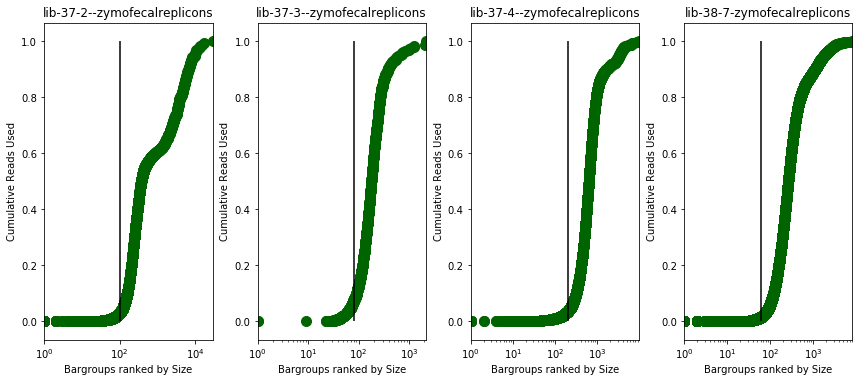

In [216]:
#QC the barcode grouped reads to remove groups that have too few reads

#vlines define the minimum number of reads that a group of reads need to contain to be considered for further analysis
vlines = [100, 80, 200, 60, 80, 80, 200, 100]

fig, axs = plot.subplots(1, len(dfs), figsize = [3*len(dfs), 5])
fig.tight_layout()    

#jackpottocurve is a cumulative histogram of the read groups based on how many reads are in the group
def jackpottocurve(fig, ax, barsize, vline):
        #prepare data to plot the jackpottocurve
        X = np.array(barsize) #make an np array of the data so we can use the various np functions
        X.sort()
        X_lorenz = X.cumsum() / X.sum() #turns it into a cumsum percentage (for y-axis)
        X_lorenz = np.insert(X_lorenz, 0, 0) #insert the 0,0 point
        X = np.insert(X, 0, 0) #insert 0,0 point for X as well
    
        ## scatter plot of the jackpottocurve (modificaiton of the lorenz curve)
        ax.scatter(X, X_lorenz, 
                   marker='o', color='darkgreen', s=100) #x axis is cumulative barcode number, yaxis is cumulative total # reads
        ax.set_title(f"lib-{prefix[i]}")
        ax.set_xlim((1,max(barsize)))
        ax.set_xscale("log", basex=10)
        ax.set_xlabel("Bargroups ranked by Size")
        ax.set_ylabel("Cumulative Reads Used")
        ax.vlines(vline, 0, 1)
        return



for i in range(len(dfs)):
    sumreads = dfs[i].sum(axis = 1)
    #plot them on the figure
    ax = axs[i]
    jackpottocurve(fig, ax, sumreads, vlines[i])



In [217]:
#cutoff dfs with less than n reads based on vlines
for i in range(len(dfs)):
    n = vlines[i]
    print(f"filtering out barcodes with less than {n} reads")
    print (f"{prefix[i]} pre-filter has {len(dfs[i])} barcodes")
    dfs[i]["num reads"] = dfs[i].sum(axis = 1)
    dfs[i] = dfs[i][dfs[i]["num reads"] >= n]
    dfs[i].drop(columns = "num reads", inplace = True)
    print (f"{prefix[i]} post-filter has {len(dfs[i])} barcodes")


filtering out barcodes with less than 100 reads
37-2--zymofecalreplicons pre-filter has 12145 barcodes
37-2--zymofecalreplicons post-filter has 10252 barcodes
filtering out barcodes with less than 80 reads
37-3--zymofecalreplicons pre-filter has 2316 barcodes
37-3--zymofecalreplicons post-filter has 1855 barcodes
filtering out barcodes with less than 200 reads
37-4--zymofecalreplicons pre-filter has 11995 barcodes
37-4--zymofecalreplicons post-filter has 9899 barcodes
filtering out barcodes with less than 60 reads
38-7-zymofecalreplicons pre-filter has 56743 barcodes
38-7-zymofecalreplicons post-filter has 52501 barcodes


/home/flan3@ad.wisc.edu/.conda/envs/default-FM/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


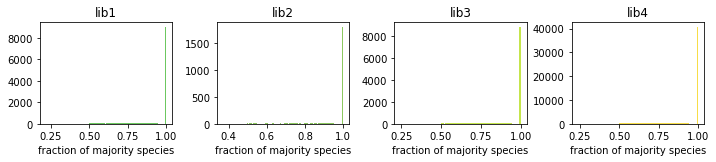

In [218]:
#check the purity of the groups - purity is defined as the fraction of reads that map to the most abundant species - 
#groups that contain only 1 species should have a purity of 1

fig, axs = plot.subplots(1,len(dfs), figsize = (10, 2))
fig.tight_layout()

for i in range(len(dfs)):
    df = rdfs[i]
    df = df.div(df.sum(axis=1), axis=0)
    purity = []
    for index, row in df.iterrows():
        purity.append(max(row))
    ax = axs[i]
    ax.hist(purity, bins = 100, color = cpallet[i])
    #ax.set_yscale("log")
    ax.set_title(f"lib{i+1}")
    ax.set_xlabel("fraction of majority species")
    
#the histogram should show the majority of barcode groups have a purity of close to 1.

In [161]:
#Summary table as a function:
#1. takes any df, normalizes it
#2. removes 16S columns and add the species name as a column
#3. discretizes presence/absence based on cutoff
#4. makes summary table

def summarytable(df, cutoff):
    #1. normalizes df
    df = df.div(df.sum(axis=1), axis=0)
    #2. removes 16S columns and add the species name as a column
    #generate 16S only subdf
    species = [s for s in df.columns if s.find("Bacteria") != -1]
    df16S = df.reindex(columns = species)
    #find the identity of the species for that barcode
    specieslist = []
    for index, row in df16S.iterrows():
        specieslist.append(df16S.columns[list(row).index(max(row))])  #find the max 16S column        
    #3. discretizes df based on cutoff
    df = df.applymap(lambda x: 0 if x <= cutoff else 1)
    #now add the species to the dfs
    df['species'] = specieslist
    #now remove the 16S columns
    ARGs = [g for g in df.columns if g.find("Bacteria") == -1 ]
    df = df.reindex(columns = ARGs)
    #4 make summary table using splitspecies
    splitspecies = df.groupby(df["species"], squeeze = True)
    #make a new df based on groups
    df = splitspecies.sum()
    #grab the total # of groups in each species
    totlist = []
    for s, d in splitspecies:
        totlist.append(len(d))
    #add this to the new df as a column
    df["num_cells"] = totlist
    #get the gene hits as fraction of total
    df = df.div(df["num_cells"], axis=0)    
    #reinstate the total again (since it got normalized)
    df["num_cells"] = totlist
    return df 

In [219]:
#ok make summary table for libraries
summary = []
n = 10 #number of reads the 16S has at least for cutoff
puritycutoff = 0.99 #the cutoff for 16S purity for saying a barcode group contains only one cell
cutoff = 0.01 #the cutoff for discretization (for saying a gene is "present")
for i in range(len(dfs)):
    df = dfs[i]
    print(f"library {prefix[i]} \n pre-cutoff # of barcodes", len(df))
    #filter the library by the 16S portion of the reads -> purity cutoffs
    species = [x for x in df.columns if x.find("Bacteria") != -1]
    ilist = [] 
    for index, row in df.iterrows():
        s = row.loc[species]
        if sum(s) > 0: #ignore the ones w/o 16S reads
            if max(s) / sum(s) >= puritycutoff and max(s) >= n: #there purity is 100% and it's more than 3 reads (100% purity is best, 1-5 reads dont' change much)
                ilist.append(index)
    df = df.reindex(index = ilist) #reindex to obtain purified df
    print(f"post-cutoff for there's only 1 16S target found and at least {n} reads \n", len(df))
    
    summary.append(summarytable(df, cutoff))

library 37-2--zymofecalreplicons 
 pre-cutoff # of barcodes 10252
post-cutoff for there's only 1 16S target found and at least 10 reads 
 7548
library 37-3--zymofecalreplicons 
 pre-cutoff # of barcodes 1855
post-cutoff for there's only 1 16S target found and at least 10 reads 
 1418
library 37-4--zymofecalreplicons 
 pre-cutoff # of barcodes 9899
post-cutoff for there's only 1 16S target found and at least 10 reads 
 7186
library 38-7-zymofecalreplicons 
 pre-cutoff # of barcodes 52501
post-cutoff for there's only 1 16S target found and at least 10 reads 
 37345


In [220]:
#Remove taxa with less than 10 cells for more robust results
for i in range(len(summary)):
    summary[i] = summary[i][summary[i]["num_cells"] > 10]

In [181]:
summary[0]

,Col156,rep-cluster-1320,rep-cluster-1351,rep-cluster-1702,rep-cluster-1778,rep-cluster-1817,rep-cluster-1868,rep-cluster-414,rep-cluster-663,num_cells
species,,,,,,,,,,
D_0__Bacteria;D_1__Actinobacteria;D_2__Actinobacteria;D_3__Actinomycetales;D_4__Actinomycetaceae,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,20
D_0__Bacteria;D_1__Actinobacteria;D_2__Actinobacteria;D_3__Bifidobacteriales;D_4__Bifidobacteriaceae,0.00e+00,5.72e-01,5.67e-01,9.30e-03,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,215
D_0__Bacteria;D_1__Actinobacteria;D_2__Coriobacteriia;D_3__Coriobacteriales;D_4__Atopobiaceae,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,18
D_0__Bacteria;D_1__Actinobacteria;D_2__Coriobacteriia;D_3__Coriobacteriales;D_4__Coriobacteriaceae,0.00e+00,0.00e+00,0.00e+00,1.81e-03,0.00e+00,0.00e+00,0.00e+00,0.00e+00,9.07e-04,1103
D_0__Bacteria;D_1__Actinobacteria;D_2__Coriobacteriia;D_3__Coriobacteriales;D_4__Coriobacteriales Incertae Sedis,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,166
D_0__Bacteria;D_1__Actinobacteria;D_2__Coriobacteriia;D_3__Coriobacteriales;D_4__Eggerthellaceae,0.00e+00,4.57e-03,4.57e-03,1.14e-02,0.00e+00,1.14e-03,0.00e+00,0.00e+00,2.29e-03,875
D_0__Bacteria;D_1__Bacteroidetes;D_2__Bacteroidia;D_3__Bacteroidales;D_4__Bacteroidaceae,0.00e+00,2.42e-03,2.42e-03,1.31e-01,0.00e+00,0.00e+00,9.69e-03,0.00e+00,1.94e-02,413
D_0__Bacteria;D_1__Bacteroidetes;D_2__Bacteroidia;D_3__Bacteroidales;D_4__Marinifilaceae,0.00e+00,0.00e+00,0.00e+00,1.33e-01,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,15
D_0__Bacteria;D_1__Bacteroidetes;D_2__Bacteroidia;D_3__Bacteroidales;D_4__Tannerellaceae,0.00e+00,0.00e+00,0.00e+00,2.86e-02,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,35


In [ ]:
#export the summary table to excel sheet for further analysis
with pd.ExcelWriter(f'{samplename}-summarytables.xlsx') as writer:  
    for i in range(len(summary)):
        summary[i].to_excel(writer, sheet_name = prefix[i])

In [ ]:
#############BELOW ARE FUNCTIONS USED TO PLOT SOME OF THE FIGURES IN THE PAPER#################

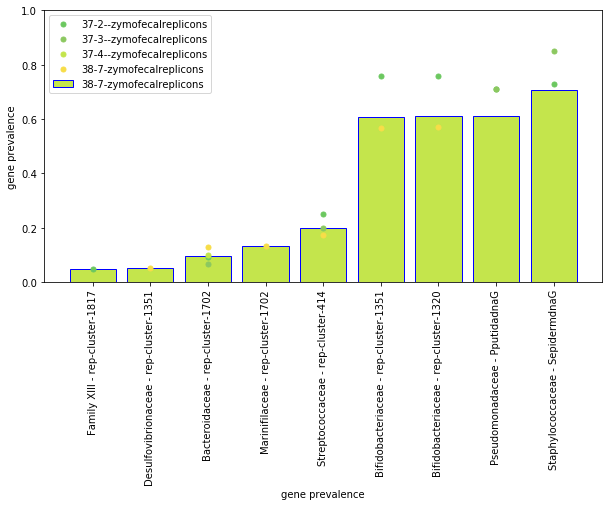

In [252]:
#plot each ARG/Species condition separately, for the glycerol stock duplicates
fig, axs = plot.subplots(1,1, figsize = (10, 5))

#sort the order by abudance (average) 
alltables = pd.concat(summary)
allmeans = alltables.groupby(level = 0).mean()
sorted_index = allmeans.sort_values("num_cells", axis = 0).index

data = []
libraries = [0,1,2,3] #libraries to include in analysis
for i in libraries:
    #ARG occupancy per ARG, barplot
    table = summary[i].drop("num_cells", axis = 1)
    #get data for each point
    names = []
    values = []
    for j, row in table.iterrows():
        for idx in row.index:
            if row[idx] >= 0.05: #only do for substantial instances (10% occupancy at least)
                names.append(str(j)+" - "+str(idx))
                values.append(row[idx])
    #store as a dataframe
    data.append(pd.DataFrame(values, index = names))

#get the sorted indices to plot in order
sorted_index = pd.concat(data).groupby(level = 0).mean().sort_values(0).index

#plot a barplot for the average of the data
#plot the average as a barplot
x = pd.concat(data).groupby(level = 0).mean()
x = x.reindex(sorted_index)
xlabels = [x.split("_")[-1] for x in x.index]

axs.bar(xlabels, x[0], color = cpallet[i+6], linewidth = 1, edgecolor = "b", label = f"{prefix[i]}")

#plot the individual datapoints
for i in libraries:
    d = data[i].reindex(sorted_index)
    axs.plot(xlabels, d.values, linestyle = "", ms = 10, color = cpallet[i], marker = ".", label = f"{prefix[i]}")
axs.tick_params(axis='x', labelrotation = 90)
axs.set_ylabel("gene prevalence")
axs.set_xlabel("gene prevalence")
axs.set_ylim((0, 1))

axs.legend()


fig.savefig("ZF-prevalences.svg", format = "svg")
